# COMP90051 Project 2

Xiuge Chen
961392

Python version: 3.7.2

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implementing ε-Greedy and UCB

In [2]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """
        
    def arg_check(self, arg_name, arg_value, size=1, dtype=None, min_value=None, max_value=None):
        """
        Check whether the argument value is in the correct data type and range, return argument value of specified data type
        
        Arguments
        =========
        arg_name : string
            name of argument, used for exception raising 
        
        arg_value : 1D array of string
            values of argument that need to be checked
            
        size : int, optional
            expected size of arguments
        
        dtype : string, optional
            data type of the argument, supported dtype: None, "string", "int" and "float"
            
        min_value : float, optional
            minimum possible value of argument
        
        max_value : float, optional
            maximum possible value of argument
            
        Returns
        =======
        out : 1D array of specified dtype (string if not specified)
            transformed arguments
        """
        # check whether parameter size is positive integer
        size = int(size)
        if size < 0:
            raise ValueError("\"size\" should be a positive integer")
        
        # raise exception if argument size doesn't match required size
        if len(arg_value) != size:
            raise ValueError("Can not check arguments have more than one value")
        
        # check the data type of arg and transform arg to that data type
        if dtype == None or dtype == "string":
            new_arg_value = np.array(arg_value)
        elif dtype == "int":
            new_arg_value = np.array(arg_value, dtype="int32")
        elif dtype == "float":
            new_arg_value = np.array(arg_value, dtype="float64")
        else:
            raise ValueError("Unkown dytype: " + str(dtype) + ", Argument: " + str(arg_name))
            
        # check whether each element of arg is in the correct range
        for i in range(size):
            if min_value != None and new_arg_value[i] < float(min_value):
                raise ValueError("Argument value less than " + str(min_value) + ", Argument: " + str(arg_name))
            
            if max_value != None and new_arg_value[i] > float(max_value):
                raise ValueError("Argument value greater than " + str(max_value) + ", Argument: " + str(arg_name))
        
        return new_arg_value

In [3]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        # arguments format/value checking, get only the first result element if parameter size is 1
        self.narms = self.arg_check(arg_name="narms", arg_value=[narms], dtype="int", min_value=0)[0]
        self.epsilon = self.arg_check(arg_name="epsilon", arg_value=[epsilon], dtype="float", min_value=0, max_value=1)[0]
        self.Q0 = self.arg_check(arg_name="Q0", arg_value=[Q0], dtype="float")[0]
            
        # initialize sum of rewards of each arm with Q0, historical appeard(pulled) time of each arm with 0
        self.sum_rewards = np.full(self.narms, self.Q0)
        self.appear_times = np.zeros(self.narms)
        
    def play(self, tround, context=None):
        # with probability epsilon, return uniformly randomly choosed arm
        if (np.random.random_sample() < self.epsilon):
            return np.random.randint(self.narms) + 1
        
        # else (probability 1-epsilon), return arm has maximum estimation value
        max_Qt_i, max_arms = np.NINF, []
        
        # loop through all arms' estimation, find the arms have maximum estimation values
        for i in range(self.narms):
            if self.appear_times[i] > 0:
                Qt_i = self.sum_rewards[i] / self.appear_times[i]
            else:
                Qt_i = self.sum_rewards[i]
            
            if Qt_i == max_Qt_i or abs(Qt_i - max_Qt_i) < 1e-6:
                max_arms.append(i)
            elif Qt_i > max_Qt_i:
                max_Qt_i = Qt_i
                max_arms = [i]
        
        # if multiple arms have the maximum value, breaks the tie randomly
        return max_arms[np.random.randint(len(max_arms))] + 1
        
    def update(self, arm, reward, context=None):
        # arguments format/value checking, get only the first result element if parameter size is 1
        arm = self.arg_check(arg_name="arm", arg_value=[arm], dtype="int", min_value=1, max_value=self.narms)[0] - 1
        reward = self.arg_check(arg_name="reward", arg_value=[reward], dtype="float")[0]
        
        # update sum of rewards and appeared times of this arm
        if self.appear_times[arm] > 0:
            self.sum_rewards[arm] += reward
            self.appear_times[arm] += 1
        else:
            self.sum_rewards[arm] = reward
            self.appear_times[arm] = 1
            
        return

In [4]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        # arguments format/value checking, get only the first result element if parameter size is 1
        self.narms = self.arg_check(arg_name="narms", arg_value=[narms], dtype="int", min_value=0)[0]
        self.rho = self.arg_check(arg_name="rho", arg_value=[rho], dtype="float", min_value=0)[0]
        self.Q0 = self.arg_check(arg_name="Q0", arg_value=[Q0], dtype="float")[0]
            
        # initialize sum of rewards of each arm with Q0, appeard time of each arm with 0
        self.sum_rewards = np.full(self.narms, self.Q0)
        self.appear_times = np.zeros(self.narms)

    def play(self, tround, context=None):
        # arguments format/value checking, get only the first result element if parameter size is 1
        tround = self.arg_check(arg_name="tround", arg_value=[tround], dtype="int", min_value=0)[0]
        
        max_Qt_i, max_arms = np.NINF, []
        
        # loop through all arms' estimation, find the arms have maximum estimation values
        for i in range(self.narms):
            if self.appear_times[i] > 0:
                u_hat_i = self.sum_rewards[i] / self.appear_times[i]
                Qt_i = u_hat_i + np.sqrt(self.rho * np.log(tround) / self.appear_times[i])
            else:
                Qt_i = self.sum_rewards[i]
            
            if Qt_i == max_Qt_i or abs(Qt_i - max_Qt_i) < 1e-6:
                max_arms.append(i)
            elif Qt_i > max_Qt_i:
                max_Qt_i = Qt_i
                max_arms = [i]
        
        # if multiple arms have the maximum value, breaks the tie randomly
        return max_arms[np.random.randint(len(max_arms))] + 1
        
    def update(self, arm, reward, context=None):
        # arguments format/value checking, get only the first result element if parameter size is 1
        arm = self.arg_check(arg_name="arm", arg_value=[arm], dtype="int", min_value=1, max_value=self.narms)[0] - 1
        reward = self.arg_check(arg_name="reward", arg_value=[reward], dtype="float")[0]
        
        # update sum of rewards and appeared times of this arm
        if self.appear_times[arm] > 0:
            self.sum_rewards[arm] += reward
            self.appear_times[arm] += 1
        else:
            self.sum_rewards[arm] = reward
            self.appear_times[arm] = 1
            
        return

## 2. The Basic Thompson Bandit

In [5]:
class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optional
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        # arguments format/value checking, get only the first result element if parameter size is 1
        self.narms = self.arg_check(arg_name="narms", arg_value=[narms], dtype="int", min_value=0)[0]
        self.alpha0 = self.arg_check(arg_name="alpha0", arg_value=[alpha0], dtype="float", min_value=0)[0]
        self.beta0 = self.arg_check(arg_name="beta0", arg_value=[beta0], dtype="float", min_value=0)[0]
        
        # initialize S and F, where Si is the posterior alpha update of arm i, 
        # Fi is the posterior beta update of arm i
        self.S = np.zeros(self.narms)
        self.F = np.zeros(self.narms)
    
    def play(self, tround, context=None):
        max_theta_i, max_arms = np.NINF, []
        
        # loop through all arms' estimation, find the arms have maximum estimation values
        for i in range(self.narms):
            theta_i = np.random.beta(self.alpha0 + self.S[i], self.beta0 + self.F[i])
            
            if theta_i == max_theta_i or abs(theta_i - max_theta_i) < 1e-6:
                max_arms.append(i)
            elif theta_i > max_theta_i:
                max_theta_i = theta_i
                max_arms = [i]
                
        # if multiple arms have the maximum value, breaks the tie randomly
        return max_arms[np.random.randint(len(max_arms))] + 1
        
    def update(self, arm, reward, context=None):
        # arguments format/value checking, get only the first result element if parameter size is 1
        arm = self.arg_check(arg_name="arm", arg_value=[arm], dtype="int", min_value=1, max_value=self.narms)[0] - 1
        reward = self.arg_check(arg_name="reward", arg_value=[reward], dtype="float")[0]
        
        # for arm i, increment S_i (update of alpha0) if the reward is 1, 
        # increment F_i (update of beta0) if the reward is 0
        if reward == 0:
            self.F[arm] += 1
        elif reward == 1:
            self.S[arm] += 1
        # reward value not valid (neither 0 nor 1), raise exception
        else:
            raise ValueError("\"reward\" should be a positive integer has value either 0 or 1")
        
        return

## 3. Off-Policy Evaluation

In [6]:
# Read dataset and transformed into suitable format: arms, rewards and contexts
DATASET = "../resources/data/dataset.txt"

arms, rewards, contexts = [], [], []
data_file = open(DATASET, 'r')
for line in data_file:
    cols = line.lstrip().rstrip().split(' ')
    
    arms.append(cols[0])
    rewards.append(cols[1])
    contexts.append(cols[2:])
    
arms = np.array(arms, dtype="int32")
rewards = np.array(rewards, dtype="float64")
contexts = np.array(contexts, dtype="float64")

In [7]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    # check whether arms, rewards and contexts have the same length
    if len(arms) != len(rewards) or len(arms) != len(contexts) or len(rewards) != len(contexts):
        raise ValueError("\"arms\", \"rewards\", and \"contexts\" should have the same length")
    
    # check whether nrounds is in the correct format (positive integer)
    nrounds = int(nrounds)
    if nrounds < 0:
        raise ValueError("\"nrounds\" should be a positive integer")
        
    # initialize R, where R contains rewards of all retained events. h parameter used in the literature to store
    # all historial retained events is not used anywhere in this type of implementation (these historical 
    # information is actually stored inside of MAB), thus not stored.
    R = []
    
    # loop through streams, until reach the end of stream or retain enough events and rewards (specified by nrounds)
    for i in range(len(arms)):
        # check whether arm is in the correct format (positive integer between 1 and mab.narms)
        arm = int(arms[i])
        if arm < 1 or arm > mab.narms:
            raise ValueError("\"arm\" should be a positive integer between 1 and " + str(self.narms))
        
        # check whether reward is in the correct format (float)
        reward = float(rewards[i])
    
        # check whether context is in the correct format (number of col equals to a positive multiple of mab.narms, and datatypes is float)
        context = np.array(contexts[i], dtype="float64")
        if len(context) % mab.narms != 0:
            raise ValueError("\"context\" should have number of columns equal to a positive multiple of mab.narms")
        
        # If the MAB chooses the same arm as the current one, retain the event, update R and MAB
        # Else do nothing
        if mab.play(tround=len(R)+1, context=contexts[i]) == arm:
            mab.update(arm=arm, reward=reward, context=contexts[i])
            R.append(reward)
        
        # Stop looping if retained enough events/rewards
        if nrounds != None and len(R) >= nrounds:
            break
        
        # Reach the end of stream but didn't retain enough events, print out warning to users
        if i == len(arms)-1 and nrounds != None:
            print("####Warning: reach the end of stream without retaining enough events, actual number of event: " + str(len(R)))
    
    return R

In [8]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.23


In [9]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.1625


In [10]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

BetaThompson average reward 0.2075


## 4. Contextual Bandits - LinUCB

In [11]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        # arguments format/value checking, get only the first result element if parameter size is 1
        self.narms = self.arg_check(arg_name="narms", arg_value=[narms], dtype="int", min_value=0)[0]
        self.ndims = self.arg_check(arg_name="ndims", arg_value=[ndims], dtype="int", min_value=0)[0]
        self.alpha = self.arg_check(arg_name="alpha", arg_value=[alpha], dtype="float", min_value=0)[0]
        
        # initialize A and b of size self.narms (create A_i and b_i for each arm i), where
        # A_i is initialized as ndims*ndims dimensional identity matrix, stores the observered context of arm i
        # b_i is initialized as ndims*1 dimensional zero vector, stores the observered reward-context combined information of arm i
        # Q_i is the inverse of A_i calculated to decrease computation cost
        A, Q, b = [], [], []
        for i in range(self.narms):
            A.append(np.identity(self.ndims))
            Q.append(np.identity(self.ndims))
            b.append(np.array([np.zeros(self.ndims)]).T)
            
        self.A = np.array(A)
        self.Q = np.array(Q)
        self.b = np.array(b)
        
    def play(self, tround, context):
        # arguments format/value checking, get only the first result element if parameter size is 1
        tround = self.arg_check(arg_name="tround", arg_value=[tround], dtype="int", min_value=0)[0]
        context = self.arg_check(arg_name="context", arg_value=context, size=self.ndims*self.narms, dtype="float")
        
        max_p_i, max_arms = np.NINF, []
        
        # loop through all arms' estimation, find the arms have maximum estimation values
        for i in range(self.narms):
            # obtain the feature vector of dimension (ndims, 1) corresponding to this arm
            x_i = np.array([ context[i*self.ndims:(i+1)*self.ndims] ]).T
            
            theta_hat_i = np.dot(self.Q[i], self.b[i])
            p_i = np.dot(theta_hat_i.T, x_i) + self.alpha * np.sqrt(np.dot(np.dot(x_i.T, self.Q[i]), x_i))
            
            if p_i == max_p_i or abs(p_i - max_p_i) < 1e-6:
                max_arms.append(i)
            elif p_i > max_p_i:
                max_p_i = p_i
                max_arms = [i]
        
        # if multiple arms have the maximum value, breaks the tie randomly
        return max_arms[np.random.randint(len(max_arms))] + 1
    
    def update(self, arm, reward, context):
        # arguments format/value checking, get only the first result element if parameter size is 1
        arm = self.arg_check(arg_name="arm", arg_value=[arm], dtype="int", min_value=1, max_value=self.narms)[0] - 1
        reward = self.arg_check(arg_name="reward", arg_value=[reward], dtype="float")[0]
        context = self.arg_check(arg_name="context", arg_value=context, size=self.ndims*self.narms, dtype="float")

        # obtain the feature vector of dimension (ndims, 1) corresponding to this arm
        x_i = np.array([ context[arm*self.ndims:(arm+1)*self.ndims] ]).T
        
        # update correspond A_i, Q_i and b_i
        self.b[arm] += np.dot(reward, x_i)
        self.A[arm] += np.dot(x_i, x_i.T)
        # check whether A_i is invertible and cached its inverse
        try:
            self.Q[arm] = np.linalg.inv(self.A[arm])
        except:
            print("[ERROR]: matrix A not invertible, update failed, skip it")
            self.A[arm] -= np.dot(x_i, x_i.T)
            self.b[arm] -= np.dot(reward, x_i)
            
        return

In [12]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 5. Contextual Bandits - LinThompson

In [13]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
        # arguments format/value checking, get only the first result element if parameter size is 1
        self.narms = self.arg_check(arg_name="narms", arg_value=[narms], dtype="int", min_value=0)[0]
        self.ndims = self.arg_check(arg_name="ndims", arg_value=[ndims], dtype="int", min_value=0)[0]
        self.v = self.arg_check(arg_name="v", arg_value=[v], dtype="float")[0]
        
        # initialize B, u_hat and f, where
        # B is initialized as ndims*ndims dimensional identity matrix, stores the observered contexts
        # f is initialized as ndims*1 dimensional zero vector, stores the observered reward-context combined information
        # u_hat is initialized as ndims*1 dimensional zero vector, stores B^-1 * f
        self.B = np.identity(self.ndims)
        self.u_hat = np.array([np.zeros(self.ndims)]).T
        self.f = np.array([np.zeros(self.ndims)]).T
        
    def play(self, tround, context):
        # arguments format/value checking, get only the first result element if parameter size is 1
        tround = self.arg_check(arg_name="tround", arg_value=[tround], dtype="int", min_value=0)[0]
        context = self.arg_check(arg_name="context", arg_value=context, size=self.ndims*self.narms, dtype="float")
        
        # sample u_sample from normal distribution N(u_hat_1D, v^2 * B^−1),
        # where B is checked invertibility at update, u_hat_1D is the 1 dimensional version of u_hat
        u_hat_1D = np.squeeze(np.asarray(self.u_hat))
        u_sample = np.random.multivariate_normal(u_hat_1D, np.dot(np.square(self.v), np.linalg.inv(self.B)))
        # transform sample results to (ndims, 1) dimensional matrix
        u_sample = np.matrix([u_sample]).T
        
        max_est, max_arms = np.NINF, []
        
        # loop through all arms' estimation, find the arms have maximum estimation values
        for i in range(self.narms):
            # obtain the feature vector of dimension (ndims, 1) corresponding to this arm
            b_it = np.array([ context[i*self.ndims:(i+1)*self.ndims] ]).T
            est = np.dot(b_it.T, u_sample)
            
            if est == max_est or abs(est - max_est) < 1e-6:
                max_arms.append(i)
            elif est > max_est:
                max_est = est
                max_arms = [i]
        
        # if multiple arms have the maximum value, breaks the tie randomly
        return max_arms[np.random.randint(len(max_arms))] + 1
    
    def update(self, arm, reward, context):
        # arguments format/value checking, get only the first result element if parameter size is 1
        arm = self.arg_check(arg_name="arm", arg_value=[arm], dtype="int", min_value=1, max_value=self.narms)[0] - 1
        reward = self.arg_check(arg_name="reward", arg_value=[reward], dtype="float")[0]
        context = self.arg_check(arg_name="context", arg_value=context, size=self.ndims*self.narms, dtype="float")
        
        # obtain the feature vector of dimension (ndims, 1) corresponding to this arm
        b_at = np.array([ context[arm*self.ndims:(arm+1)*self.ndims] ]).T
        
        # update B, f and u_hat
        self.B += np.dot(b_at, b_at.T)
        self.f += np.dot(reward, b_at)
        # check whether B is invertible and update u_hat
        try:
            self.u_hat = np.dot(np.linalg.inv(self.B), self.f)
        except:
            print("[ERROR]: matrix B not invertible, update failed, skip it")
            self.B -= np.dot(b_at, b_at.T)
            self.f -= np.dot(reward, b_at)
        
        return

In [14]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.3075


## 6. Evaluation
### 6.A. 

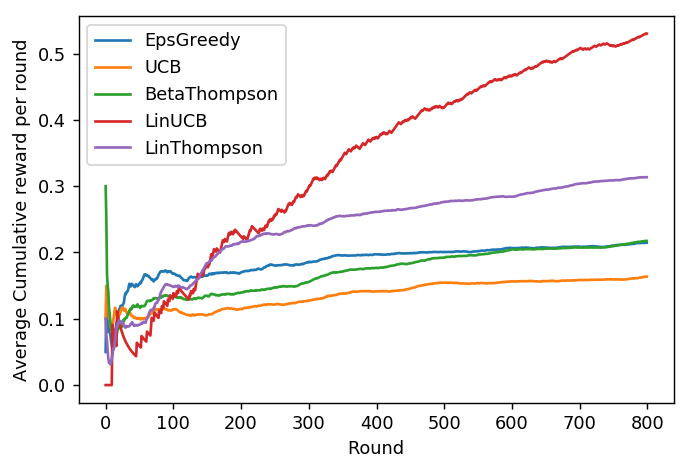

In [15]:
# calculate the running per-round cumulative reward over MAX_ROUND round, for all 5 different MABs above
# repeat calculation for NUM_EXPERIMENT experiments, plot the average per-round cumulative reward of different MABs

# settings
NUM_ROUND = 800
NUM_EXPERIMENT = 20

titles = ["EpsGreedy",
          "UCB",
          "BetaThompson",
          "LinUCB",
          "LinThompson"]

results = {}
for title in titles:
    results[title] = np.zeros(NUM_ROUND)

# run NUM_EXPERIMENT experiments
for i in range(NUM_EXPERIMENT): 
    # every experiment need to initialize new mabs to evaluate
    mabs = [EpsGreedy(10, 0.05),
            UCB(10, 1.0),
            BetaThompson(10, 1.0, 1.0),
            LinUCB(10, 10, 1.0),
            LinThompson(10, 10, 1.0)]
    
    for title, mab in zip(titles, mabs):
        result = offlineEvaluate(mab, arms, rewards, contexts, NUM_ROUND)
        result_cum = np.cumsum(result)
    
        # calculate per-round cumulative reward from cumulative sum of rewards
        for j in range(NUM_ROUND):
            result_cum[j] /= j + 1
        
        results[title] += result_cum
        
    print("####INFO: progress " + "{0:.0%}".format((i+1) / NUM_EXPERIMENT), end='\r')

# calculate average per-round cumulative reward
for title in titles:
    results[title] /= NUM_EXPERIMENT
    
# plot the results
plt.rcParams["figure.dpi"] = 128
# plot all mabs
for title in titles:
    plt.plot(results[title], label=title)
plt.xlabel("Round")
plt.ylabel("Average Cumulative reward per round")
plt.legend()

### 6.B.

Top  1 result, alpha value:  0.0200, average cumulative reward:  0.7312
Top  2 result, alpha value:  0.0100, average cumulative reward:  0.7300
Top  3 result, alpha value:  0.0300, average cumulative reward:  0.7250
Top  4 result, alpha value:  0.0500, average cumulative reward:  0.7238
Top  5 result, alpha value:  0.0800, average cumulative reward:  0.7150
Top  6 result, alpha value:  0.0400, average cumulative reward:  0.7137
Top  7 result, alpha value:  0.1000, average cumulative reward:  0.7088
Top  8 result, alpha value:  0.0900, average cumulative reward:  0.7075
Top  9 result, alpha value:  0.0600, average cumulative reward:  0.7063
Top  10 result, alpha value:  0.0700, average cumulative reward:  0.7013


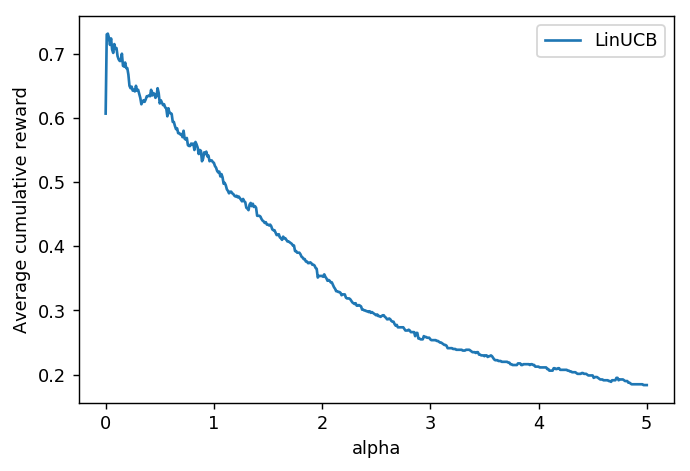

In [16]:
# Grid-search based strategies to select the α hyperparameter in LinUCB
# output a graph that plots the average cumulative reward of different alpha

# change parameter below to adjust grid search settings 
# According to the literature, alpha of LinUCB is calculated as 1 + (ln(2/delta) / 2)^(1/2), where delta is the 
# probability that inequlity not holds. So even if we take delta as a fairly small value like 0.0001, alpha is just 
# about 3.225. Therefore, it is suffice to test alpha with maximum value of 5. Although accroding to the formula,
# alpha should be at least 1 (theoretically), but values between 0 and 1 actually does not make the bandit fail or 
# perform extremely worse, so here I adopt the minimum test value as 0.
MIN_VALUE = 0
MAX_VALUE = 5
INTERVAL = 0.01
# number of rounds performed to calculate cumulative reward
NUM_ROUND = 800
# number of experiments performed to calculate each average cumulative reward
NUM_EXPERIMENT = 20
# number of top results needed to be print out
NUM_TOP = 10

steps = np.arange(start = MIN_VALUE, stop = MAX_VALUE + 0.001, step = INTERVAL)

# loop through all possible alpha value between MIN_VALUE and MAX_VALUE, with interval INTERVAL
# calculate average cumulative reward of NUM_ROUND rounds over NUM_EXPERIMENT experiments
avg_cum_reward = []
for alpha in steps:
    result = 0
    for _ in range(NUM_EXPERIMENT):
        mab = LinUCB(10, 10, alpha=alpha)
        result += np.mean(offlineEvaluate(mab, arms, rewards, contexts, NUM_ROUND))
        
    avg_cum_reward.append(result / NUM_EXPERIMENT)
    print("####INFO: progress " + "{0:.0%}".format((alpha - MIN_VALUE) / (MAX_VALUE - MIN_VALUE)), end='\r')

# plot the results
plt.rcParams["figure.dpi"] = 128
plt.plot(steps, avg_cum_reward, label="LinUCB")
plt.xlabel("alpha")
plt.ylabel("Average cumulative reward")
plt.legend()

# print top 10 results, obtain the index of ascendingly sorted results, 
# than start printing from the last one, until reach the beginning or obtain NUM_TOP top results
sorted_index = np.argsort(avg_cum_reward)

if NUM_TOP > len(sorted_index):
    NUM_TOP = len(sorted_index)

for i in range(len(sorted_index) - 1, len(sorted_index) - 1 - NUM_TOP, -1):
    print("Top % 2d result, alpha value: % 2.4f, average cumulative reward: % 2.4f"
          % (len(sorted_index)-i, steps[sorted_index[i]], avg_cum_reward[sorted_index[i]]) )

Top  1 result, v value:  0.0300, average cumulative reward:  0.4408
Top  2 result, v value:  0.0500, average cumulative reward:  0.4405
Top  3 result, v value:  0.0200, average cumulative reward:  0.4354
Top  4 result, v value:  0.0400, average cumulative reward:  0.4347
Top  5 result, v value:  0.0700, average cumulative reward:  0.4346
Top  6 result, v value:  0.0600, average cumulative reward:  0.4297
Top  7 result, v value:  0.0900, average cumulative reward:  0.4279
Top  8 result, v value:  0.1000, average cumulative reward:  0.4268
Top  9 result, v value:  0.0000, average cumulative reward:  0.4263
Top  10 result, v value:  0.0100, average cumulative reward:  0.4257


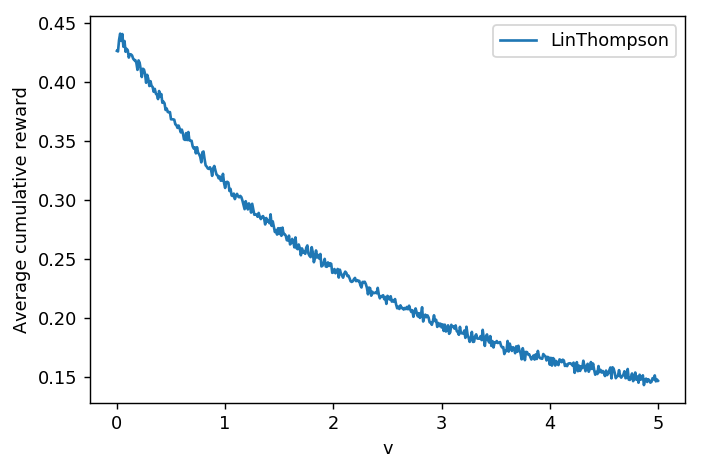

In [17]:
# Grid-search based strategies to select the v hyperparameter in LinThompson
# output a graph that plots the average cumulative reward of different v 

# change parameter below to adjust grid search settings
# Although parameter v for LinThompson is allowed to be negative, the algorithm actually uses v^2 in sampling,
# therefore it is suffice to just test positive v values.
# Again according to the literature, v is calculated as R * (24/epsilon * d * ln(1/delta))^(1/2), where delta is the 
# probability of "fails", d is the dimension, R and epsilon are just constant. So the value of v could be fairly large.
# Therefore, firstly I test v with maximum value 200, minimum value 0 and interval of 1, the result shows that the 
# average cumulative reward decreases graduatelly as v increases. Then, I decrease the maximum value to 5 and make 
# the interval smaller, so that the best parameter v could be measured more accurately.
MIN_VALUE = 0
MAX_VALUE = 5
INTERVAL = 0.01
# number of rounds performed to calculate cumulative reward
NUM_ROUND = 800
# number of experiments performed to calculate each average cumulative reward
NUM_EXPERIMENT = 20
# number of top results needed to be print out
NUM_TOP = 10

steps = np.arange(start = MIN_VALUE, stop = MAX_VALUE + 0.001, step = INTERVAL)

# loop through all possible alpha value between MIN_VALUE and MAX_VALUE, with interval INTERVAL
# calculate average cumulative reward of NUM_ROUND rounds over NUM_EXPERIMENT experiments
avg_cum_reward = []
for v in steps:
    result = 0
    for _ in range(NUM_EXPERIMENT):
        mab = LinThompson(10, 10, v=v)
        result += np.mean(offlineEvaluate(mab, arms, rewards, contexts, NUM_ROUND))
        
    avg_cum_reward.append(result / NUM_EXPERIMENT)
    print("####INFO: progress " + "{0:.0%}".format((v - MIN_VALUE) / (MAX_VALUE - MIN_VALUE)), end='\r')
    
# plot the results
plt.rcParams["figure.dpi"] = 128
plt.plot(steps, avg_cum_reward, label="LinThompson")
plt.xlabel("v")
plt.ylabel("Average cumulative reward")
plt.legend()

# print top 10 results, obtain the index of ascendingly sorted results, 
# than start printing from the last one, until reach the beginning or obtain NUM_TOP top results
sorted_index = np.argsort(avg_cum_reward)

if NUM_TOP > len(sorted_index):
    NUM_TOP = len(sorted_index)

for i in range(len(sorted_index) - 1, len(sorted_index) - 1 - NUM_TOP, -1):
    print("Top % 2d result, v value: % 2.4f, average cumulative reward: % 2.4f"
          % (len(sorted_index)-i, steps[sorted_index[i]], avg_cum_reward[sorted_index[i]]) )

## Appendix
#### Self test on artifitial generated data

In [ ]:
# Self test 
# plot average rewards on artifitial generated data from normal distribution, as shown in lecture slides
# only suitable for non-context mabs
NUM_ROUND = 500
NUM_EXPERIMENT = 1000

titles = ["EpsGreedy",
          "UCB"]
          #"BetaThompson"]
    
# results from 5 MABs
results = {}
for title in titles:
    results[title] = np.zeros(NUM_ROUND)

for j in range(NUM_EXPERIMENT):
    mabs = [EpsGreedy(10, 0.05),
            UCB(10, 1.0)]
            #BetaThompson(10, 1.0, 1.0)]
        
    u = np.random.normal(0, 1, size=10)
        
    for i in range(NUM_ROUND):
        for title, mab in zip(titles, mabs):
            arm = mab.play(tround=i+1)
            reward = np.random.normal(u[arm-1], 1)
            '''
            uncommect this if want test beta thompson
            if reward > 0:
                reward = 1
            else:
                reward = 0
            '''
            mab.update(arm=arm, reward=reward)
            results[title][i] += reward
    
    print("####INFO: progress " + "{0:.0%}".format(j / NUM_EXPERIMENT), end='\r')

# calculate average rewards of different experiments
for title in titles:
    for i in range(NUM_ROUND):
        results[title][i] = results[title][i] / NUM_EXPERIMENT
    
# plot the results
plt.rcParams["figure.dpi"] = 128
for title in titles:
    plt.plot(results[title], label=title)
plt.xlabel("Round")
plt.ylabel("Average reward")
plt.legend()